In [42]:
from scipy import io
import numpy as np
import pandas as pd

from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard

matlab = matlab_reader('AIRS_40KM_2022/20220125_AIRS_3DST-1_40km_grid.mat')
grid = map_grid()
wizard = data_wizard()


In [43]:
temp_data = matlab.select(
    hemisphere= 'sh',
    data_field='tp',
    daytime='night',
    altitude=36)   
    
select_area_indexer = grid.select_area_indexer(
    min_lat= -34,
    max_lat= -22,
    min_lon= -74,
    max_lon= -63)


(501, 501)


In [40]:
data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = temp_data)

In [41]:
mean = dataset(data).mean

In [72]:
from os import listdir
from os.path import isfile, join
from datetime import datetime

def extract_date(filename):
    date_string = filename.split("_")[0]
    date_obj = datetime.strptime(date_string, '%Y%m%d')
    return date_obj.date()

FILES = np.sort(listdir('AIRS_40KM_2018/'))
FILES_DATE = [extract_date(file) for file in FILES]

In [73]:
means = []
for file in FILES:
    try:
        matlab = matlab_reader('AIRS_40KM_2018/' + file)
        full_data = matlab.select(
            hemisphere= 'sh',
            data_field='tp',
            daytime='night',
            altitude=36)   
            
        select_area_indexer = grid.select_area_indexer(
            min_lat= -34,
            max_lat= -22,
            min_lon= -74,
            max_lon= -63)

        selected_data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = full_data)
        mean = dataset(selected_data).mean
        means.append(mean)
    except:
        pass


(501, 501)
(501, 501)
(501, 501)
(501, 501)


/Users/joaojesus/Desktop/FinalYearProject/classes/grid_funcs.py:34: RuntimeWarning: Mean of empty slice
  self.mean = np.nanmean(data)
/Users/joaojesus/Desktop/FinalYearProject/classes/grid_funcs.py:35: RuntimeWarning: All-NaN slice encountered
  self.max = np.nanmax(data)
/Users/joaojesus/Desktop/FinalYearProject/classes/grid_funcs.py:36: RuntimeWarning: All-NaN slice encountered
  self.min = np.nanmin(data)


(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)
(501, 501)

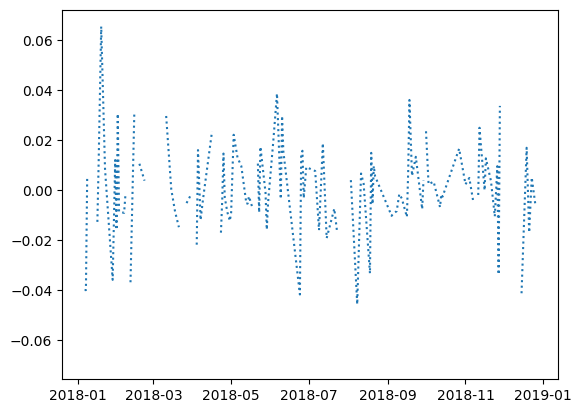

In [76]:
import matplotlib.pyplot as plt
import numpy as np
y = means
x = FILES_DATE[:len(means)]
plt.plot(x,y, linestyle = 'dotted')
plt.show()

In [57]:
len(means)

61

In [63]:
len(np.arange(1,len(means)+1))

61